In [2]:
!pip install langchain langgraph langchain-google-genai google-generativeai

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00


In [49]:
from google.colab import userdata

from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage

from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field

import operator

In [50]:
api_key = userdata.get("GOOGLE_API_KEY")

In [74]:
generator_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=api_key
)

In [75]:
evaluator_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=api_key
)

In [76]:
optimizer_llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=api_key
)

In [77]:
class TweetEvaluation(BaseModel):
  evaluation: Literal['approved', 'needs improvement'] = Field(description="Whether the tweet is approved or needs improvement.")
  feedback: str = Field(description="One paragraph explaining the strengths and weaknesses.")

In [78]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [79]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal['approved', 'needs improvement']
    feedback: str
    iteration: int
    max_iterations: int
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [80]:
def generate_tweet(state: TweetState) -> TweetState:
  messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
                      Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

                      Rules:
                      - Do NOT use question-answer format.
                      - Max 280 characters.
                      - Use observational humor, irony, sarcasm, or cultural references.
                      - Think in meme logic, punchlines, or relatable takes.
                      - Use simple, day to day English.
                    """)
    ]

  response = generator_llm.invoke(messages).content

  return {'tweet': response, 'tweet_history': [response]}

In [81]:
def evaluate_tweet(state: TweetState) -> TweetState:
  messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
                  Evaluate the following tweet:

                  Tweet: "{state['tweet']}"

                  Use the criteria below to evaluate the tweet:

                  1. Originality – Is this fresh, or have you seen it a hundred times before?
                  2. Humor – Did it genuinely make you smile, laugh, or chuckle?
                  3. Punchiness – Is it short, sharp, and scroll-stopping?
                  4. Virality Potential – Would people retweet or share it?
                  5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

                  Auto-reject if:
                  - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                  - It exceeds 280 characters
                  - It reads like a traditional setup-punchline joke
                  - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

                  ### Respond ONLY in structured format:
                  - evaluation: "approved" or "needs_improvement"
                  - feedback: One paragraph explaining the strengths and weaknesses
                """)
  ]

  response = structured_evaluator_llm.invoke(messages)

  return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [82]:
def optimize_tweet(state: TweetState) -> TweetState:
  messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
                      Improve the tweet based on this feedback:
                      "{state['feedback']}"

                      Topic: "{state['topic']}"
                      Original Tweet:
                      {state['tweet']}

                      Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
                    """)
    ]

  response = optimizer_llm.invoke(messages).content

  iteration = state['iteration'] + 1

  return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [83]:
def route_evaluation(state: TweetState) -> str:
  if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
    return 'approved'
  else:
    return 'needs improvement'

In [84]:
graph = StateGraph(TweetState)

In [85]:
graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

In [86]:
graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')
graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

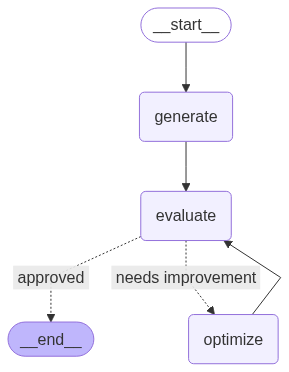

In [87]:
workflow = graph.compile()
workflow

In [88]:
initial_state = {
    'topic': 'politics',
    'tweet': '',
    'evaluation': 'needs improvement',
    'feedback': '',
    'iteration': 1,
    'max_iterations': 5,
    'tweet_history': [],
    'feedback_history': []
}

final_state = workflow.invoke(initial_state)

In [89]:
print(final_state)

{'topic': 'politics', 'tweet': 'My 2016 political self is currently haunting my therapist. Send wine and maybe an exorcist. #PoliticalRegret #WineTherapy #SendHelp', 'evaluation': 'approved', 'feedback': 'The tweet displays a decent level of originality, humorously tapping into the relatable experience of political evolution and its psychological impact.  The self-deprecating tone and the call for "wine and an exorcist" add to its comedic effect. It\'s punchy and concise, fitting within the character limit.  The hashtags are relevant and could boost virality. The format is well-suited for Twitter, avoiding typical pitfalls like question-answer structures or lengthy setups. Overall, it\'s a solid tweet with good potential for engagement.', 'iteration': 4, 'max_iterations': 5, 'tweet_history': ["My therapist told me to embrace my mistakes... so I'm embracing my entire political stance from 2016.  Send help (and maybe a time machine). #politicalregrets #stillnotsorry #sendwine", 'Here are